# Convergence Test

Simulating  SA-OT with iterated learning to measure how quickly new learner agents born with different grammars adopt the grammar of a teacher (adult) agent. The goal is to understand how stable a target grammar is (in this case, Hierarchy 1) under transmission through GLA-based learning. We analyze:
- How many learning iterations are needed for agents starting from different grammars to converge to H1.
- How consistent that convergence is across multiple independent simulations.
- Whether certain starting grammars (e.g., H2 vs. H6) make convergence easier or harder. 

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

from saot import *

In [10]:
def convergence_test_to_hierarchy(n_runs=100, max_iters=300, k_values='default', verbose=False):
    """
    Simulates learning from an adult agent (H1) by learners starting with different grammars (H2 to H6)
    until their grammar matched the hierarchy of the adult agent or a maximum number of learning iterations
    is reached.
    
    Args:
        n_runs (int): Number of independent simulation runs per starting grammar.
        max_iters (int): Maximum learning iterations per agent.
        k_values (str or list): Initial K-values for all agents, including adult.
        verbose (bool): Whether to print detailed output.
        
    Returns:
        all_learning_iters (np.ndarray): Convergence iteration counts (n_runs x 5 for H2-H6).
    """

    hierarchy_nums = list(range(2, 7))  # H2 to H6
    n_agents = len(hierarchy_nums)
    conv_iters_matrix = np.zeros((n_runs, n_agents))
    
    local_optima_per_run = []

    for run in range(n_runs):        
        if run % 10 == 0:
            print(f"Run {run + 1}/{n_runs}...")

        # Initialize the adult agent with the specified hierarchy and k-values
        adult_agent = SAOTAgent(id=0, hierarchy_name='H1', k_values=k_values)
        if verbose:
            print(f"Adult agent (H1): {adult_agent}")

        # Initialize a dictionary to store local optima produced by each agent while learning
        local_optima = {}

        # Iterate over hierarchies, creating a new agent for each
        for j, h in enumerate(hierarchy_nums):
            # Create a new agent with the current hierarchy
            new_agent = SAOTAgent(id=h, hierarchy_name=f'H{h}', k_values=k_values)
            if verbose:
                print(f"\nNew agent (H{h}): {new_agent}")
            count = 0
            total_productions_per_h = defaultdict(int)

            # The new agent learns from the adult agent until it converges to the same hierarchy
            while new_agent.hierarchy_name != adult_agent.hierarchy_name:
                if count > max_iters:
                    conv_iters_matrix[run, j] = np.nan  # did not converge
                    print(f"  At run {run+1} agent {new_agent.initial_hierarchy_name} did not converge after {max_iters} iterations.")
                    break
                count += 1
                
                # Get the hierarchy before learning 
                current_h = new_agent.hierarchy_name
                observed_sf = adult_agent.produce_sf()
                new_agent.learn_from(observed_sf, verbose=False)
                if verbose:
                    print(f"Agent {new_agent.initial_hierarchy_name} after update {count}: {new_agent}")
                # Count production under the hierarchy used to produce
                total_productions_per_h[current_h] += 1
            
            local_optima_stats = {}
            for h in hierarchy_nums: 
                assert total_productions_per_h[f'H{h}'] >= len(new_agent.local_optima_produced[f'H{h}']), "Local optima produced cannot exceed total productions."
                local_optima_stats[f'H{h}'] = (new_agent.local_optima_produced[f'H{h}'], total_productions_per_h[f'H{h}']) 
            
            local_optima[f'Agent {new_agent.initial_hierarchy_name}'] = local_optima_stats
            
            if verbose:
                print(f"Agent {new_agent.initial_hierarchy_name} settled on {new_agent.hierarchy_name} after {count} iterations.")
                print(f"Local optima produced: {new_agent.local_optima_produced}")

            if count <= max_iters:
                conv_iters_matrix[run, j] = count
        
        local_optima_per_run.append(local_optima)
        
    return conv_iters_matrix, local_optima_per_run

In [11]:
n_runs = 100
hierarchy_nums = list(range(2, 7))  # H2 to H6
labels = [f'H{h}' for h in hierarchy_nums]

# Run simulations with default and random k-values
print(f"Running convergence test with default k-values...")
conv_iters_matrix_default, local_optima_per_run_default = convergence_test_to_hierarchy(n_runs=n_runs, max_iters=300, k_values='default', verbose=False)
assert conv_iters_matrix_default.shape == (n_runs, len(hierarchy_nums)), "Shape mismatch for default K-values."

print(f"\nRunning convergence test with random float k-values...")
conv_iters_matrix_random, local_optima_per_run_random = convergence_test_to_hierarchy(n_runs=n_runs, max_iters=300, k_values='random', verbose=False)
assert conv_iters_matrix_random.shape == (n_runs, len(hierarchy_nums)), "Shape mismatch for random K-values."

Running convergence test with default k-values...
Run 1/100...
Run 11/100...
Run 21/100...
Run 31/100...
Run 41/100...
Run 51/100...
Run 61/100...
Run 71/100...
Run 81/100...
Run 91/100...

Running convergence test with random float k-values...
Run 1/100...
Run 11/100...
Run 21/100...
Run 31/100...
Run 41/100...
Run 51/100...
Run 61/100...
Run 71/100...
Run 81/100...
Run 91/100...


In [12]:
# Combined results in one dataframe
data = []

for run_idx in range(n_runs):
    for agent_idx, h in enumerate(hierarchy_nums):
        data.append({
            'start_hierarchy': f'H{h}',
            'iterations': conv_iters_matrix_random[run_idx, agent_idx],
            'strategy': 'random'
        })
        data.append({
            'start_hierarchy': f'H{h}',
            'iterations': conv_iters_matrix_default[run_idx, agent_idx],
            'strategy': 'default'
        })

df = pd.DataFrame(data)
display(df.head())

,start_hierarchy,iterations,strategy
0,H2,19.0,random
1,H2,24.0,default
2,H3,66.0,random
3,H3,30.0,default
4,H4,9.0,random


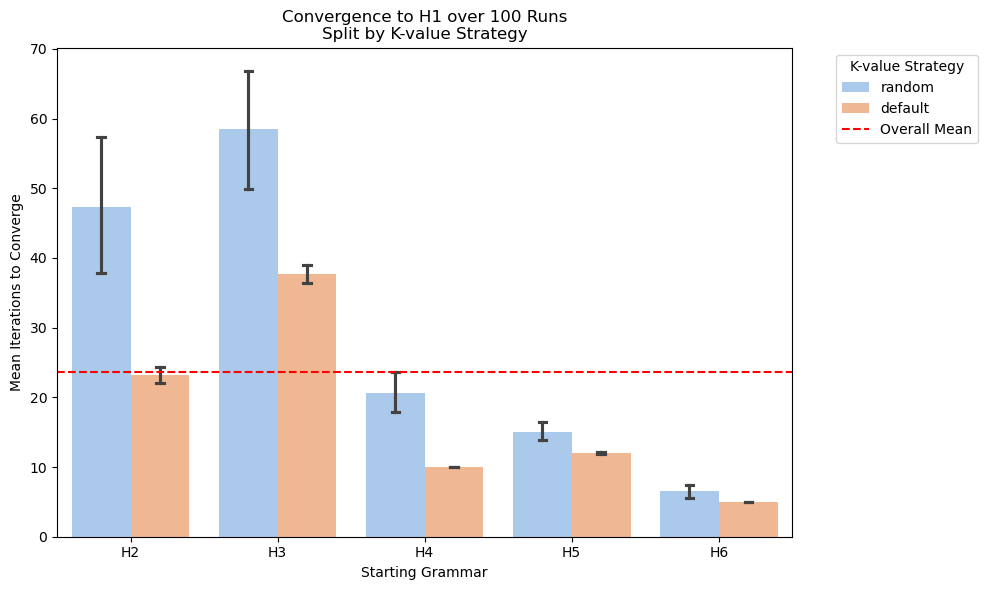

In [13]:
# ----- Barplot -----
plt.figure(figsize=(10, 6))

# Barplot with automatic CI (95% by default)
ax = sns.barplot(
    data=df,
    x='start_hierarchy',
    y='iterations',
    hue='strategy',
    capsize=0.1,
    errorbar='ci',  
    palette='pastel'
)

# Add global mean line
global_mean = df['iterations'].mean()
plt.axhline(global_mean, linestyle='--', color='red', label='Overall Mean')

plt.xlabel('Starting Grammar')
plt.ylabel('Mean Iterations to Converge')
plt.title(f'Convergence to H1 over {n_runs} Runs\nSplit by K-value Strategy')
plt.legend(title='K-value Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


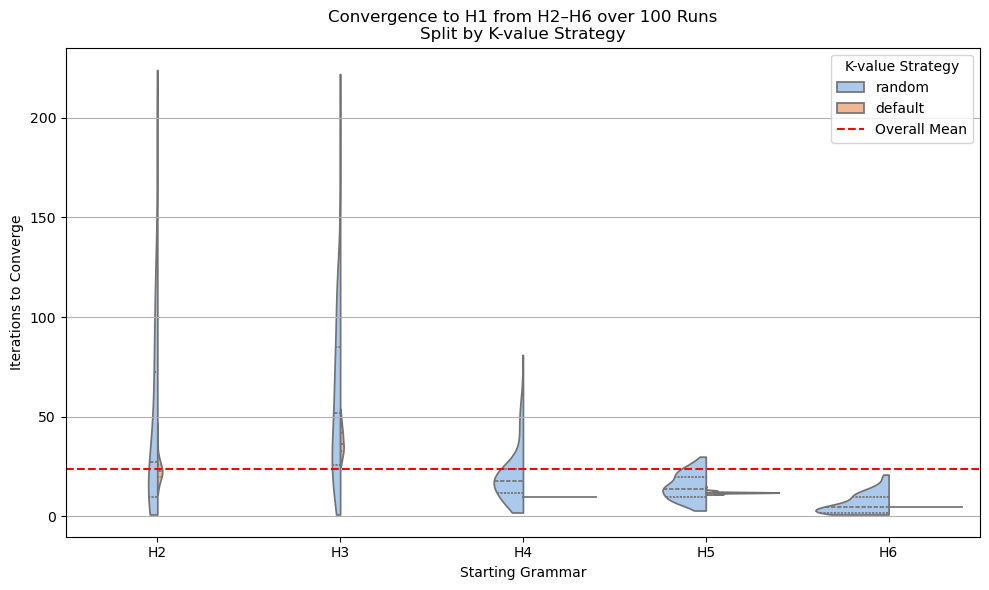

In [14]:
# ----- Violin plot -----
plt.figure(figsize=(10, 6))

sns.violinplot(
    data=df,
    x='start_hierarchy',
    y='iterations',
    hue='strategy',
    split=True,
    inner='quartile',
    cut=0,
    palette='pastel',
)

plt.axhline(df['iterations'].mean(), linestyle='--', color='red', label='Overall Mean')

plt.title(f'Convergence to H1 from H2–H6 over {n_runs} Runs\nSplit by K-value Strategy')
plt.xlabel("Starting Grammar")
plt.ylabel("Iterations to Converge")
plt.grid(axis='y')
plt.legend(title="K-value Strategy")
plt.tight_layout()
plt.show()

Agents' initial grammar seems to have a large effect on their learning rate given H1-generated learning data.

## Local Optima Produced

The effect observed above may be due to the type of stage -- pure or mixed -- that the hierarchy represents. If it is mixed, the surface forms produced by agents may be global or local optima for their hierarchy. Since learning is based on a comparison between predicted and target surface forms, whether an agent produces a local or a global optimum at each learning step will have an effect on how fast it converges to the target grammar hierarchy. 

,Agent,Hierarchy,Value,K Setting
0,Agent H2,H2,0.416667,Default
1,Agent H2,H2,0.303030,Default
2,Agent H2,H2,0.666667,Default
3,Agent H2,H2,0.370370,Default
4,Agent H2,H2,0.344828,Default


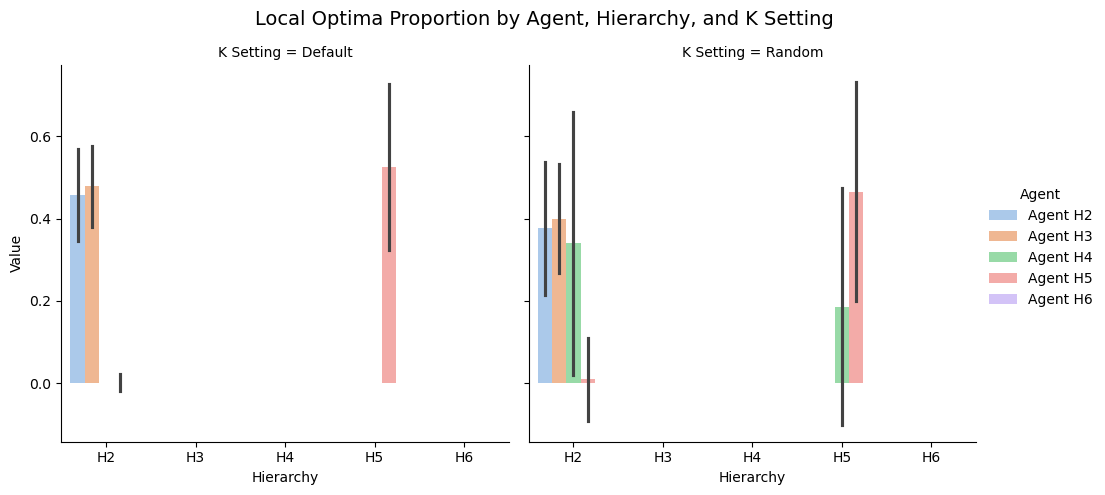

In [15]:
def aggregate_local_optima_stats(local_optima_per_run, normalize=False):
    """
    Count (or normalize) occurrences of surface forms that are local optima.

    Args:
        local_optima_per_run (list): List of dicts: 
            {agent: {hierarchy: ([surface_form_str], total_productions)}}
        normalize (bool): Whether to return proportions instead of raw counts.

    Returns:
        dict: agent -> hierarchy -> list of (normalized) counts from all runs.
    """
    stats = defaultdict(lambda: defaultdict(list))
    
    for run in local_optima_per_run:
        for agent, optima in run.items():
            for h, (local_optima, total_productions) in optima.items():
                count = len(local_optima)
                if normalize:
                    count = count / total_productions if total_productions > 0 else 0
                    assert count <= 1, f"Proportion exceeds 1: {count} for {agent} under hierarchy {h}. Total productions: {total_productions}, Local optima: {local_optima}"
                stats[agent][h].append(count)
    
    # Ensure all agents and hierarchies have the same number of runs
    for agent, hierarchies in stats.items():
        for h, values in hierarchies.items():
            assert len(values) == n_runs, f"Mismatch in number of runs for {agent} under hierarchy {h}."
    
    return stats


def stats_to_long_df(stats_dict, k_setting_name=None):
    """
    Convert nested stats dict (agent -> hierarchy -> list of values) to long-form DataFrame.

    Args:
        stats_dict (dict): Nested dict from aggregate_local_optima_stats.
        k_setting_name (str, optional): Label for K-value condition.

    Returns:
        pd.DataFrame: Long-format DataFrame with columns:
                      ['Agent', 'Hierarchy', 'Value', 'K Setting']
    """
    rows = []
    for agent, hierarchies in stats_dict.items():
        for h, values in hierarchies.items():
            for v in values:
                rows.append({
                    'Agent': agent,
                    'Hierarchy': h,
                    'Value': v,
                    'K Setting': k_setting_name or 'Unknown'
                })
    return pd.DataFrame(rows)


# Aggregate stats (nested dicts)
normalize = True  # Set to True to get proportions instead of counts
value = 'Proportion' if normalize else 'Count'
agg_default = aggregate_local_optima_stats(local_optima_per_run_default, normalize=normalize)
agg_random = aggregate_local_optima_stats(local_optima_per_run_random, normalize=normalize)

# Convert to long DataFrames with a label for each K setting
df_default = stats_to_long_df(agg_default, k_setting_name="Default")
df_random = stats_to_long_df(agg_random, k_setting_name="Random")

# Combine both conditions into a single DataFrame
df_all = pd.concat([df_default, df_random], ignore_index=True)
display(df_all.head())

# sns.boxplot(
#     data=df_all,
#     x='Hierarchy',
#     y='Value',
#     hue='Agent',
#     palette='pastel',
# )
# plt.title(f"Local Optima {value} per Hierarchy by Agent")
# plt.ylabel(f"{value} of Local Optima")
# plt.xlabel("Initial Hierarchy")
# plt.grid(axis='y')
# plt.tight_layout()
# plt.show()

sns.catplot(
    data=df_all,
    kind='bar',
    x='Hierarchy',
    y='Value',
    hue='Agent',
    col='K Setting',
    errorbar='sd',
    palette='pastel',
)

plt.subplots_adjust(top=0.87)
plt.suptitle(f"Local Optima {value} by Agent, Hierarchy, and K Setting", fontsize=14)
plt.show()

As expected, local optima are only produced with hierarchies representing mixed stages (H2 and H5). 

# Production Patterns After Learning

In [139]:
def convergence_test_productions(learning_iters=30, production_sample=100, observed_sf = ['SN', 'V'], k_values='default', verbose=False):
    """
    Simulate learning from a given surface form by learners starting with different grammars (H2 to H6). 
    Record a production sample from agents after learning is complete.
    
    Args:
        n_runs (int): Number of independent simulation runs per starting grammar.
        learning_iters (int): Number of learning iterations per agent.
        k_values (str or list): Initial K-values for all agents, including adult.
        verbose (bool): Whether to print detailed output.
        
    Returns:
        production_history (dict): Dictionary with hierarchy names as keys and lists of produced surface forms (serialized) as values.
    """

    hierarchies = list(range(2, 7))  # H2 to H6

    production_history = {f'H{h}': [] for h in hierarchies}
    
    # Iterate over hierarchies, creating a new agent for each
    for h in hierarchies:
        # Create a new agent with the current hierarchy
        new_agent = SAOTAgent(id=h, hierarchy_name=f'H{h}', k_values=k_values)
        if verbose:
            print(f"\nNew agent (H{h}): {new_agent}")

        # The new agent goes through the specified number of learning iterations
        for i in range(learning_iters):
            new_agent.learn_from(observed_sf, verbose=False)
            if verbose:
                print(f"Agent {new_agent.initial_hierarchy_name} after update {i+1}: {new_agent}")
        
        # Record productions for the current agent
        for _ in range(production_sample):
            produced_sf = new_agent.produce_sf()          
            production_history[f'H{h}'].append(serialize_sf(produced_sf, flat=True))
    
    return production_history


def run_multiple_convergence_tests(n_runs=10, learning_iters=30, production_sample=100, observed_sf=['SN', 'V'], k_values='default', verbose=False):
    all_counts = []

    for run in range(n_runs):
        if verbose or run % 10 == 0:
            print(f"Run {run+1}/{n_runs}...")

        production_history = convergence_test_productions(
            learning_iters=learning_iters, 
            production_sample=production_sample, 
            observed_sf=observed_sf, 
            k_values=k_values, 
            verbose=verbose
        )

        # Convert to DataFrame
        production_df = pd.DataFrame(production_history).melt(var_name='Initial Hierarchy', value_name='Surface Form')
        
        # Count occurrences of each surface form per hierarchy
        surface_form_counts = (
            production_df.groupby(['Initial Hierarchy', 'Surface Form'])
            .size()
            .reset_index(name='Count')
        )
        surface_form_counts['Run'] = run
        all_counts.append(surface_form_counts)

    return pd.concat(all_counts, ignore_index=True)


stats = run_multiple_convergence_tests(n_runs=100, learning_iters=30, production_sample=100, verbose=False)
stats_display = stats.pivot_table(index='Surface Form', columns='Initial Hierarchy', values='Count', fill_value=0)
print("-" * 40)
print(f"\nSurface Form Count by Initial Hierarchy:")
print(stats_display)

Run 1/100...
Run 11/100...
Run 21/100...
Run 31/100...
Run 41/100...
Run 51/100...
Run 61/100...
Run 71/100...
Run 81/100...
Run 91/100...
----------------------------------------

Surface Form Count by Initial Hierarchy:
Initial Hierarchy     H2         H3     H4     H5     H6
Surface Form                                            
[SN V SN]          45.25  45.406977    0.0   1.00    0.0
[SN V]             96.38  60.950000  100.0  99.99  100.0


## Effect of Number of Learning Iterations


--- Sweeping Learning Iterations: 20 ---
Run 1/100...
Run 11/100...
Run 21/100...
Run 31/100...
Run 41/100...
Run 51/100...
Run 61/100...
Run 71/100...
Run 81/100...
Run 91/100...

--- Sweeping Learning Iterations: 25 ---
Run 1/100...
Run 11/100...
Run 21/100...
Run 31/100...
Run 41/100...
Run 51/100...
Run 61/100...
Run 71/100...
Run 81/100...
Run 91/100...

--- Sweeping Learning Iterations: 30 ---
Run 1/100...
Run 11/100...
Run 21/100...
Run 31/100...
Run 41/100...
Run 51/100...
Run 61/100...
Run 71/100...
Run 81/100...
Run 91/100...

--- Sweeping Learning Iterations: 35 ---
Run 1/100...
Run 11/100...
Run 21/100...
Run 31/100...
Run 41/100...
Run 51/100...
Run 61/100...
Run 71/100...
Run 81/100...
Run 91/100...

--- Sweeping Learning Iterations: 40 ---
Run 1/100...
Run 11/100...
Run 21/100...
Run 31/100...
Run 41/100...
Run 51/100...
Run 61/100...
Run 71/100...
Run 81/100...
Run 91/100...

--- Sweeping Learning Iterations: 50 ---
Run 1/100...
Run 11/100...
Run 21/100...
Run 31/100..

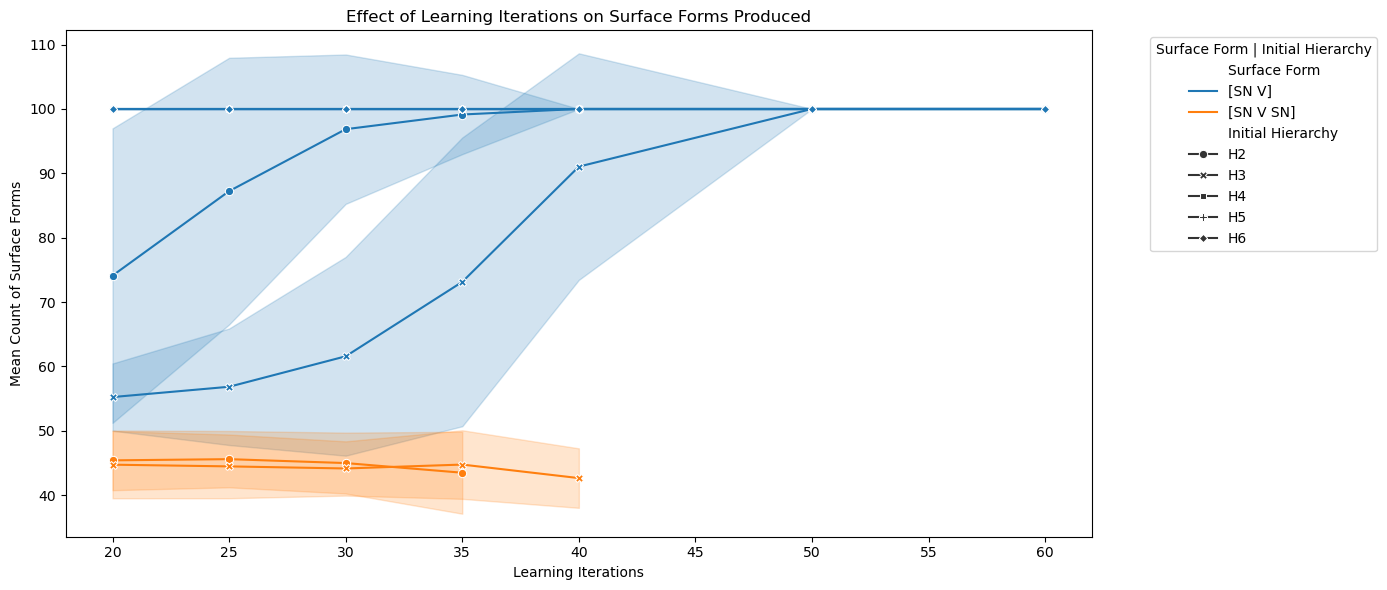

In [140]:
def sweep_learning_iters(iters_list, n_runs=10, production_sample=100, observed_sf=['SN', 'V'], k_values='default'):
    sweep_results = []

    for iters in iters_list:
        print(f"\n--- Sweeping Learning Iterations: {iters} ---")
        run_df = run_multiple_convergence_tests(
            n_runs=n_runs,
            learning_iters=iters,
            production_sample=production_sample,
            observed_sf=observed_sf,
            k_values=k_values,
            verbose=False
        )
        run_df['Learning Iters'] = iters
        sweep_results.append(run_df)

    return pd.concat(sweep_results, ignore_index=True)

# Define the list of learning iterations to sweep
learning_iters_list = [20, 25, 30, 35, 40, 50, 60]
# Run the sweep across the specified learning iterations
sweep_df = sweep_learning_iters(learning_iters_list, n_runs=100, production_sample=100)


# ----- Plotting the results of the sweep -----
plt.figure(figsize=(14, 6))

sns.lineplot(
    data=sweep_df,
    x='Learning Iters',
    y='Count',
    hue='Surface Form',              # Color by Surface Form
    style='Initial Hierarchy',       # Marker by Initial Hierarchy
    markers=True,
    dashes=False,
    err_style="band",                # Confidence interval as band
    errorbar='sd',                   # Use standard deviation for error bands
    estimator='mean'                 # Plot the mean over runs
)

plt.title('Effect of Learning Iterations on Surface Forms Produced')
plt.ylabel('Mean Count of Surface Forms')
plt.xlabel('Learning Iterations')
plt.legend(title='Surface Form | Initial Hierarchy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()